# **1. MDP Solver**

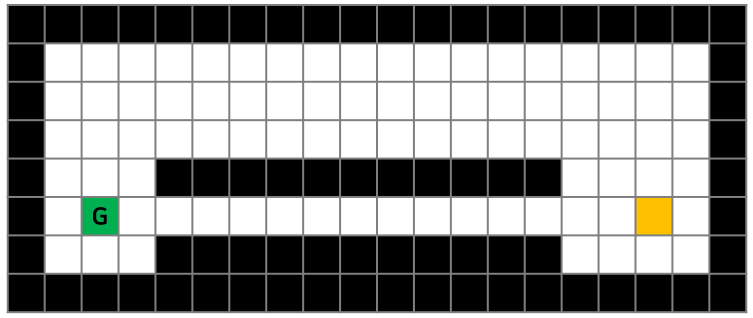

- State Set $X= \{(0, 0), (0, 1), \cdots  ,(19,7)\}$

- Agent action set $U = \{ ↑, ↓, ←, →\}$

- Nature action set $Θ= \{⋅, ↑, ↓, ←, →\}$

- State transition probability
  
      액션대로 진행될 확률: 90%
      액션의 진행방향 기준으로 좌우로 빗겨나갈 확률: 각각 5%

  (Example)

  $P(θ= ⋅ | u=↑) = 0.9$

  $P(θ=← | u=↑) = 0.05$

  $P(θ=→ | u=↑) = 0.05$

- Reward function

  $r(x, u) = \left\{ \begin{matrix} 100 & If \; x = x_{G}\\ -1 & o/w  \end{matrix} \right.$

- Initial state $x_{I} \in X$

- Goal state $x_{G} = (i, j) = (2, 2)$

- Policy $\pi(x_k) = u_k$


> 이 문제는 Agent가 Nature 및 Environment에 관한 모든 정보를 알고 있으므로 **'Model Based'** 문제이다
>
>  => *강화학습이 아니다. MDP 문제이다!.*
>


## **(0) Setting**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib import animation, rc

Figure Functions

In [ ]:
############################################
#             Figure Functions             #
############################################
global G, Policy, Gsto, T, Num_unchage
offset = 0.15


def colorsquare(i, j, c):
    x = xdim[0] + ((i - 1) * dx) + offset
    y = ydim[0] + ((j - 1) * dy) + offset
    if Hcolor[i][j] == 0:
        Hcolor[i][j] = patches.Rectangle((x, y), dx, dy, facecolor=c, edgecolor=0.8 * np.ones(3), fill=True)


def labelsquare(i, j, s):
    x = xdim[0] + ((i + 0.5 - 1) * dx) + offset
    y = ydim[0] + ((j + 0.5 - 1) * dy) + offset
    if Hcost[i][j] == 0:
        Hcost[i][j] = plt.text(x, y, s, fontsize=10, color='r', horizontalalignment='center')
    else:
        Hcost[i][j] = "{0:.1f}".format(G[i][j])


def actionsquare(i, j, d):
    x = xdim[0] + ((i + 0.5 - 1) * dx) + offset
    y = ydim[0] + ((j + 0.5 - 1) * dy) + offset

    if d != 0:
        D = []
        D.append([0, dy])
        D.append([0, -dy])
        D.append([dx, 0])
        D.append([-dx, 0])

        D = np.array(D)
        D = D.transpose()
        d = int(d - 1)

        xx = x + D[0, d] * np.array([0.35, 0.45])
        yy = y + D[1, d] * np.array([0.35, 0.45])
        if Haction[i][j] == 0:
            Haction[i][j] = plt.plot(xx, yy, color='b', linewidth=2)
            Haction[i][j] = Haction[i][j][0]
        else:
            Haction[i][j].set_data(xx, yy)
    else:
        if Haction[i][j] == 0:
            Haction[i][j] = plt.plot(0, 0, color='b', linewidth=2)
            Haction[i][j] = Haction[i][j][0]

Environment Setting

In [ ]:
#############################################
#           Environment Setting             #
#############################################

# Minimum grid resulution
res = 0.15

# Dimensions of the world
xdim = [-1.45, 1.45]
ydim = [-0.6, 0.6]

# Number of grid cells (가장 가까운 큰 수 정수 변환)
nx = int(np.ceil((xdim[1] - xdim[0]) / res))  # 8
ny = int(np.ceil((ydim[1] - ydim[0]) / res))  # 20

# Size of grid cells (for plot)
dx = (xdim[1] - xdim[0]) / nx  # 0.145
dy = (ydim[1] - ydim[0]) / ny  # 0.15

# Reward of goal, collision, movement.
vGoal = 100
vObst = -100
vMove = -1

# 특정 지역 제외, 초기 value.
vInitial = 0

# 지도 그리기
obst = [[], []]
obst[0].extend(list(range(nx)))
obst[0].extend(list(range(nx)))
obst[0].extend(np.zeros(ny))
obst[0].extend((nx - 1) * np.ones(ny))
obst[0].extend(list(range(4, nx - 4)))
obst[0].extend(list(range(4, nx - 4)))

obst[1].extend(np.zeros(nx))
obst[1].extend((ny - 1) * np.ones(nx))
obst[1].extend(list(range(ny)))
obst[1].extend(list(range(ny)))
obst[1].extend(1 * np.ones(len(list(range(4, nx - 4)))))
obst[1].extend(3 * np.ones(len(list(range(4, nx - 4)))))

obst = np.array(obst, dtype=np.int8)

isobst = np.zeros((nx, ny))
for k in range(len(obst[0])):
    isobst[obst[0, k], obst[1, k]] = 1

isgoal = np.zeros((nx, ny))
isgoal[2, 2] = 1

# Percentage of error
# Action시, 90% -> 정상 방향, 5% -> 주변 방향
perr = 0.1

In [ ]:
#############################################
#             Environment Plot              #
#############################################
# 이미지의 크기 설정
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

# 첫 번째 subplot
ax[0].imshow(isobst.T)
ax[0].set_title('Obstacle')
ax[0].grid(which="both", linestyle='-', linewidth=1, color='black', alpha=0.5)
ax[0].set_xticks(np.arange(0.5, 20, 1))
ax[0].set_yticks(np.arange(0.5, 8, 1))
ax[0].invert_yaxis()  # y축 뒤집기

# 두 번째 subplot
ax[1].imshow(isgoal.T)
ax[1].set_title('Goal')
ax[1].grid(which="both", linestyle='-', linewidth=1, color='black', alpha=0.5)
ax[1].set_xticks(np.arange(0.5, 20, 1))
ax[1].set_yticks(np.arange(0.5, 8, 1))
ax[1].invert_yaxis()  # y축 뒤집기

# subplot 간의 간격 늘리기
plt.subplots_adjust(hspace=0.2)

# 플롯 보여주기
plt.show()

## **(1) Value Iteration**

- 현재 policy의 변화 없이 cost-to-go $G$를 구하는 것을 의미합니다.

- **Value iteration**은 policy iteration의 **policy evaluation(prediction)**과 동일합니다.

- Value iteration은 식에서도 알 수 있듯이 policy를 만들기 위한 식이 아닙니다.

- 물론, value table이 수렴하고 그 값이 낮아지는 방향으로 policy를 생성할 수 있습니다.

###[1] Initialization

In [ ]:
############################################
#         Initialization Function          #
############################################
def Initialize():
    G = np.zeros((nx, ny))        # Value function
    Policy = np.zeros((nx, ny))   # Policy
    for x in range(nx):
        for y in range(ny):
            if isobst[x, y] == 1:
                G[x, y] = vObst
            elif isgoal[x, y] == 1:
                G[x, y] = vGoal
            else:
                G[x, y] = vInitial
                Policy[x, y] = np.ceil(4 * np.random.rand())
    return G, Policy

####################################
#          Figure  Handle          #
####################################
fig = plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 1, 1)
Hcolor = np.zeros((nx, ny)).tolist()
Hcost = np.zeros((nx, ny)).tolist()
Haction = np.zeros((nx, ny)).tolist()

#############################################
#       Plot Initial Value and Policy       #
#############################################
G, Policy = Initialize()

for i in range(nx):
    ax.plot((xdim[0] + (i / (nx)) * (xdim[1] - xdim[0])) * np.array([1, 1]), ydim, color=0.8 * np.ones(3))

for i in range(ny):
    ax.plot(xdim, (ydim[0] + (i / (ny)) * (ydim[1] - ydim[0])) * np.array([1, 1]), color=0.8 * np.ones(3))

for x in range(nx):
    for y in range(ny):
        if isgoal[x, y] == 1:
            colorsquare(x, y, 'g')
            ax.add_patch(Hcolor[x][y])
        elif isobst[x, y] == 1:
            colorsquare(x, y, 'k')
            ax.add_patch(Hcolor[x][y])
        else:
            colorsquare(x, y, 'w')
            ax.add_patch(Hcolor[x][y])
        labelsquare(x, y, "{0:.1f}".format(G[x, y]))
        actionsquare(x, y, Policy[x][y])

###[2] Value Iteration

**Value Iteration**

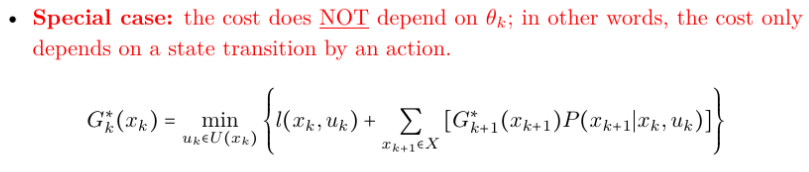

**Optimal Policy**

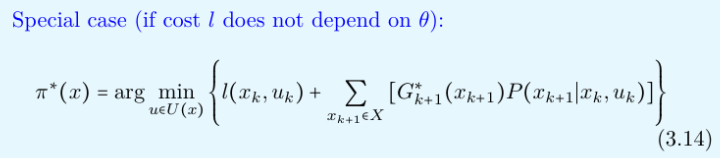

> 위 수식은 cost function에 대한 것이므로, 실습에서는 아래와 같은 reward function 형태로 코딩한다.

**Value Iteration**

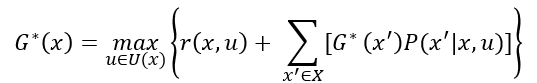

In [ ]:
#############################################
#         Value Iteration Function          #
#############################################
def dovalueiteration(G):
    Gprev = G.copy()
    for x in range(nx):
        for y in range(ny):
            if isgoal[x][y] == 0 and isobst[x][y] == 0:
                #####################################################
                # Get next step value: G(x')
                # x: x-axis, y: y-axis.
								# Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [1, 2, 3, 4]
                Gn = Gprev[x, y + 1]
                Gs = Gprev[x, y - 1]
                Ge = Gprev[x + 1, y]
                Gw = Gprev[x - 1, y]

                #####################################################
                # Compute All Next Value
								# Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [1, 2, 3, 4]
                # r(x,u) + sum(G P)
                Gu1 = -1 + ((1 - perr) * Gn + (perr / 2) * Ge + (perr / 2) * Gw)
                Gu2 = -1 + ((1 - perr) * Gs + (perr / 2) * Ge + (perr / 2) * Gw)
                Gu3 = -1 + ((1 - perr) * Ge + (perr / 2) * Gn + (perr / 2) * Gs)
                Gu4 = -1 + ((1 - perr) * Gw + (perr / 2) * Gn + (perr / 2) * Gs)
                GtU = [Gu1, Gu2, Gu3, Gu4]

                #####################################################
                # Fill Your Code!
								# G(x) = max(r(x,u) + sum(G(x')P(x'|x,u)))
                G[None][None] = None
                #####################################################

    return G

**Optimal Policy**

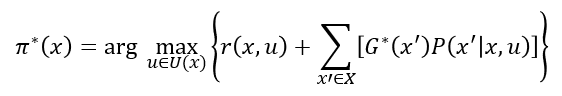

In [ ]:
#############################################
#         Value to Policy Function          #
#############################################
def value2policy(G, Policy):
    for x in range(nx):
        for y in range(ny):
            if isgoal[x][y] == 0 and isobst[x][y] == 0:
                #####################################################
                # i: x-axis, j: y-axis.
								# Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [1, 2, 3, 4]
                Gn = G[x, y + 1]
                Gs = G[x, y - 1]
                Ge = G[x + 1, y]
                Gw = G[x - 1, y]

                #####################################################
								# Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [1, 2, 3, 4]
                # r(x,u) + sum(G P)
                Gu1 = -1 + ((1 - perr) * Gn + (perr / 2) * Ge + (perr / 2) * Gw)
                Gu2 = -1 + ((1 - perr) * Gs + (perr / 2) * Ge + (perr / 2) * Gw)
                Gu3 = -1 + ((1 - perr) * Ge + (perr / 2) * Gn + (perr / 2) * Gs)
                Gu4 = -1 + ((1 - perr) * Gw + (perr / 2) * Gn + (perr / 2) * Gs)
                GU = [Gu1, Gu2, Gu3, Gu4]

                #####################################################
                # Fill Your Code!
                # Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [1, 2, 3, 4]
                # Policy(x) = arg max(r(x,u) + sum(G(x')P(x'|x,u)))
                Policy[None][None] = None + 1

    return Policy

In [ ]:
############################################
#    Value Iteration Animator Function     #
############################################
def value_animate(k):
    global G, Policy, Gsto, Num_unchage

    # Save previous policy
    Policy_prev = Policy.copy()

    #######################################
    #           Value Iteration           #
    #######################################
    # Fill Your Code!
    if k != 0:
      G = dovalueiteration(G)
      Policy = value2policy(G, Policy)
    #######################################

    # Compute unchage
    Num_unchage[k] = np.count_nonzero(Policy - Policy_prev)
    Gsto[k, :] = np.reshape(G, -1)

    # Animation update
    ax.set_title("iter=" + str(k))
    for x in range(nx):
        for y in range(ny):
            Hcost[x][y].set_text("{0:.1f}".format(G[x][y]))
            actionsquare(x, y, Policy[x][y])
            if Policy[x][y] != Policy_prev[x][y]:
                Hcolor[x][y].set_facecolor('yellow')
            else:
                ccur = Hcolor[x][y].get_facecolor()
                if ccur == (1, 1, 0, 1):
                    Hcolor[x][y].set_facecolor('white')

    # Animation handles
    Handle = ()
    for x in range(nx):
        for y in range(ny):
            Handle = Handle + (Hcolor[x][y],)
            Handle = Handle + (Hcost[x][y],)
            Handle = Handle + (Haction[x][y],)

    return Handle

###[3] Main

In [ ]:
####################################
#            		Main	             #
####################################
# Parameter Setting
T = 70
G, Policy = Initialize()
Num_unchage = np.zeros(T)
Gsto = np.zeros((T, len(np.reshape(G, -1))))

# Algorithm + Animation
anim = animation.FuncAnimation(fig, value_animate, frames=T, interval=500, blit=True)
rc('animation', html='jshtml')
HTML(anim.to_jshtml())

###[4] Result

In [ ]:
############################################
#           Result Plot Function           #
############################################
def displayresults(T, Gsto, uchange):
  plt.figure(figsize=(10, 8))
  plt.clf()

  plt.plot(range(T), Gsto, 'k-')
  for t in range(T):
    if uchange[t] == 1:
      plt.plot([t, t], [-100, -100+(200*uchange[t]/(nx*ny))], color='r', linewidth=3)

  plt.title("Last change at iteration "+str(np.where(uchange==1)[-1][-1]))

displayresults(T, Gsto, Num_unchage)

## **(2) Policy Iteration**

- Policy iteration은 **1. policy evaluation**과 **2. policy improvement** 두 과정의 반복 입니다.

- **1. Policy evaluation**은 <font color='red'>**value function의 prediction** </font>과정입니다.

- **2. Policy improvement**는 evaluation된 cost-to-go $G(x)$를 $G^*$로 **가정**하고, policy를 update합니다

- Policy iteration은 policy를 improvement하면서 value table을 도출해내기 때문에, **control** 이라고도 합니다.

- Policy iteration은 prediction된 value function을 바탕으로 feedback control과 같이 policy를 구하기 때문에 **control** 이라고도 합니다.

- Policy improvement가 더이상 진행되지 않을 때 까지 반복합니다(모든 state에서 policy update가 없을 때 까지).

###[1] Initialization

In [ ]:
####################################
#          Figure  Handle          #
####################################
fig = plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 1, 1)
Hcolor = np.zeros((nx, ny)).tolist()
Hcost = np.zeros((nx, ny)).tolist()
Haction = np.zeros((nx, ny)).tolist()

#############################################
#       Plot Initial Value and Policy       #
#############################################
G, Policy = Initialize()

for i in range(nx):
    ax.plot((xdim[0] + (i / (nx)) * (xdim[1] - xdim[0])) * np.array([1, 1]), ydim, color=0.8 * np.ones(3))

for i in range(ny):
    ax.plot(xdim, (ydim[0] + (i / (ny)) * (ydim[1] - ydim[0])) * np.array([1, 1]), color=0.8 * np.ones(3))

for x in range(nx):
    for y in range(ny):
        if isgoal[x, y] == 1:
            colorsquare(x, y, 'g')
            ax.add_patch(Hcolor[x][y])
        elif isobst[x, y] == 1:
            colorsquare(x, y, 'k')
            ax.add_patch(Hcolor[x][y])
        else:
            colorsquare(x, y, 'w')
            ax.add_patch(Hcolor[x][y])
        labelsquare(x, y, "{0:.1f}".format(G[x, y]))
        actionsquare(x, y, Policy[x][y])

###[2] Policy Iteration

**Policy Evaluation**

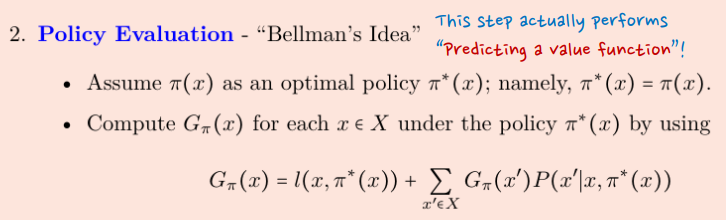

**Policy Improvement**

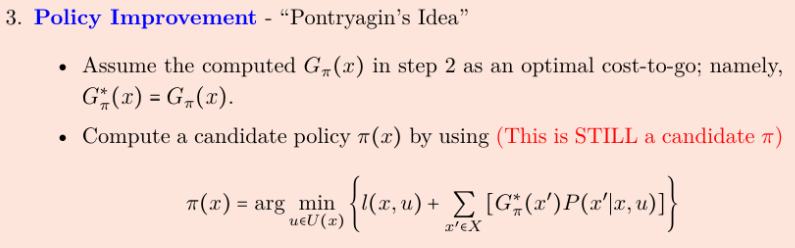

> 위 수식은 cost function에 대한 것이므로, 실습에서는 아래와 같은 reward function 형태로 코딩한다.

**Policy Evaluation**

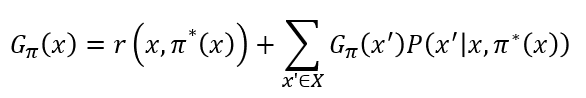

**Policy Improvement**

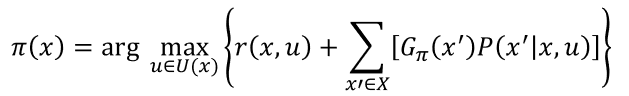

In [ ]:
#############################################
#         Policy Iteration Function         #
#############################################
def dopolicyiteration(G, Policy):
    Gprev = G.copy()

    ####################################
    #       (1) Policy Evaluation      #
    ####################################
    for x in range(nx):
        for y in range(ny):
            if isgoal[x][y] == 0 and isobst[x][y] == 0:
                #####################################################
                # Get optimal action from policy
                # Fill Your Code!
                action = Policy[x,y]

                # Get next step value: G(x')
                Gn = Gprev[x, y + 1]
                Gs = Gprev[x, y - 1]
                Ge = Gprev[x + 1, y]
                Gw = Gprev[x - 1, y]

                # 1: North
                if action == 1:
                    G[x][y] = -1 + ((1 - perr) * Gn + (perr / 2) * Ge + (perr / 2) * Gw)
                # 2: South
                elif action == 2:
                    G[x][y] = -1 + ((1 - perr) * Gs + (perr / 2) * Ge + (perr / 2) * Gw)
                # 3: East
                elif action == 3:
                    G[x][y] = -1 + ((1 - perr) * Ge + (perr / 2) * Gn + (perr / 2) * Gs)
                # 4: West
                elif action == 4:
                    G[x][y] = -1 + ((1 - perr) * Gw + (perr / 2) * Gn + (perr / 2) * Gs)

    ####################################
    #      (2) Policy Improvement      #
    ####################################
    for x in range(nx):
        for y in range(ny):
            if isgoal[x][y] == 0 and isobst[x][y] == 0:
                #####################################################
								# Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [1, 2, 3, 4]
                Gn = G[x, y + 1]
                Gs = G[x, y - 1]
                Ge = G[x + 1, y]
                Gw = G[x - 1, y]

                #####################################################
								# Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [1, 2, 3, 4]
                # r(x,u) + sum(G P)
                Gu1 = -1 + ((1 - perr) * Gn + (perr / 2) * Ge + (perr / 2) * Gw)
                Gu2 = -1 + ((1 - perr) * Gs + (perr / 2) * Ge + (perr / 2) * Gw)
                Gu3 = -1 + ((1 - perr) * Ge + (perr / 2) * Gn + (perr / 2) * Gs)
                Gu4 = -1 + ((1 - perr) * Gw + (perr / 2) * Gn + (perr / 2) * Gs)
                GU = [Gu1, Gu2, Gu3, Gu4]

                #####################################################
                # Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [1, 2, 3, 4]
                # Fill Your Code!
                Policy[None][None] = np.argmax(None) + 1

    return G, Policy

In [ ]:
def policy_animate(k):
    global G, Policy, Gsto, Num_unchage

    # Save previous policy
    Policy_prev = Policy.copy()

    # Policy Iteration
    if k != 0:
      G, Policy = dopolicyiteration(G, Policy)

    # Compute unchage
    Num_unchage[k] = np.count_nonzero(Policy - Policy_prev)
    Gsto[k, :] = np.reshape(G, -1)

    # Animation update
    ax.set_title("iter=" + str(k))
    for x in range(nx):
        for y in range(ny):
            Hcost[x][y].set_text("{0:.1f}".format(G[x][y]))
            actionsquare(x, y, Policy[x][y])
            if Policy[x][y] != Policy_prev[x][y]:
                Hcolor[x][y].set_facecolor('yellow')
            else:
                ccur = Hcolor[x][y].get_facecolor()
                if ccur == (1, 1, 0, 1):
                    Hcolor[x][y].set_facecolor('white')

    # Animation handles
    Handle = ()
    for x in range(nx):
        for y in range(ny):
            Handle = Handle + (Hcolor[x][y],)
            Handle = Handle + (Hcost[x][y],)
            Handle = Handle + (Haction[x][y],)

    return Handle

###[3] Main

In [ ]:
####################################
#            		Main	             #
####################################
# Parameter Setting
T = 70
G, Policy = Initialize()
Num_unchage = np.zeros(T)
Gsto = np.zeros((T, len(np.reshape(G, -1))))

# Algorithm + Animation
anim = animation.FuncAnimation(fig, policy_animate, frames=T, interval=500, blit=True)
rc('animation', html='jshtml')
HTML(anim.to_jshtml())

###[4] Result

In [ ]:
def displayresults(T, Gsto, uchange):
  plt.figure(figsize=(10, 8))
  plt.clf()

  plt.plot(range(T), Gsto, 'k-')
  for t in range(T):
    if uchange[t] == 1:
      plt.plot([t, t], [-100, -100+(200*uchange[t]/(nx*ny))], color='r', linewidth=3)

  plt.title("Last change at iteration "+str(np.where(uchange==1)[-1][-1]))

displayresults(T, Gsto, Num_unchage)

# **2. Model-Free MDP Solver(Without Error)**

In [ ]:
#nature action과 reward fuction을 모를때 free ,,,, 정확히는 agent를 모를때..?
# state : 4*4 action 4*1 q-table 4*4*4

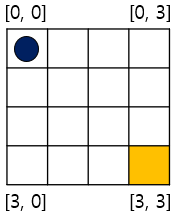

- State Set $X= \{(0, 0), (0, 1), \cdots  ,(x,y)\}$

- Agent action set $U = \{ ↑, ↓, ←, →\}$

- Nature action set $Θ= \{⋅\}$

- State transition probability : **action 100% 수행**

- Reward function

  $r(x, u) = \left\{ \begin{matrix} -100 & If \; x = x_{obst}\\ -1 & o/w  \end{matrix} \right.$

- Initial state $x_{I} \in X$

- Goal state $x_{G} = (x_G, y_G)$

- Policy $\pi(x_k) = u_k$

### [0] Environment Class

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#############################################
#           GridWorld Parameters            #
#############################################
x_size = 10
y_size = 6
x_goal = 3
y_goal = 3
x_obstacles = [2, 5, 7, 3]
y_obstacles = [2, 4, 5, 5]
Obstacles = list(zip(x_obstacles, y_obstacles))


#############################################
#           GridWorld Environment           #
#############################################
class GridWorld():
    def __init__(self):
        self.x = 0
        self.y = 0

    def step(self, a):
        # Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [0, 1, 2, 3]
        # Action Step
        if a == 0:
            self.move_up()
        elif a == 1:
            self.move_down()
        elif a == 2:
            self.move_right()
        elif a == 3:
            self.move_left()

        # Compute Reward
        if (self.x, self.y) in Obstacles:
            reward = -100
            self.reset()
        else:
            reward = -1

        # Compute Done!
        done = self.is_done()

        return (self.x, self.y), reward, done

    def move_right(self):
        self.y += 1
        if self.y > y_size-1:
            self.y-=1

    def move_left(self):
        self.y -= 1
        if self.y < 0:
            self.y+=1

    def move_up(self):
        self.x -= 1
        if self.x < 0:
            self.x+=1

    def move_down(self):
        self.x += 1
        if self.x > x_size-1:
            self.x-=1

    def is_done(self):
        if self.x == x_goal and self.y == y_goal:
            return True
        else:
            return False

    def get_state(self):
        return (self.x, self.y)

    def reset(self):
        self.x = np.random.choice([0, x_size-1])
        self.y = np.random.choice([0, y_size-1])
        return (self.x, self.y)

## **(1) SARSA**

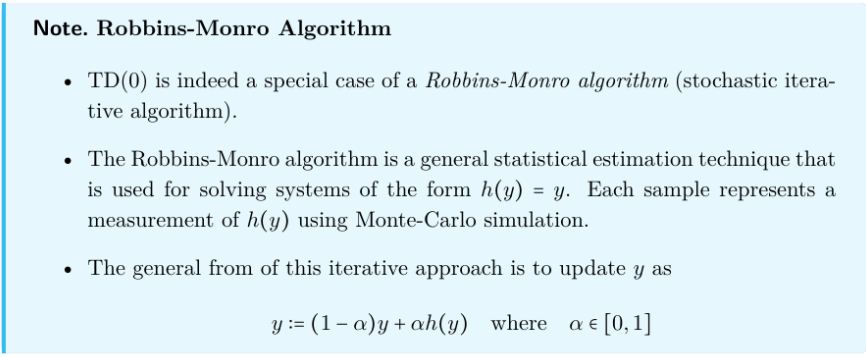

### [1] SARSA Agent Class

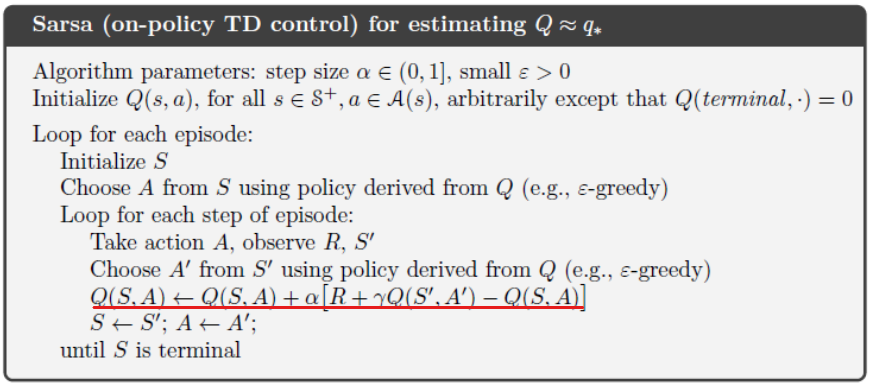

fil code가 위 빨가줄을 코드로 구현한것

In [ ]:
#############################################
#                Agent Class                #
#############################################
class AgentSARSA():
  def __init__(self):
    self.q_table = np.zeros((x_size,y_size,4)) # x size, y size, number of action #!!!!!!!!!!!!!!!!!!!!!444444444444444
    self.eps = 0.9
    self.alpha = 0.1

  def select_action(self, s): #이리저리 돌아다니면서 탐색 위,아래,왼,오 25%로 해서
    # epsilon-soft greedy policy
    x, y = s
    prob =  random.random()
    if prob < self.eps: # perform random action with epsilon probabilty
      action = random.randint(0,3)
    else: # greedy
      action_val = self.q_table[x,y,:]
      action = np.argmax(action_val) #q_tabel에서 내 action을 뽑아온다 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 내 q를 가장 크게 만드는 action(argmax)
    return action

  def update_table(self, transition):
    # Now, input for the update is a sigle state transition
    s,a,r,s_next = transition
    x,y = s
    x_next, y_next = s_next
    a_next = self.select_action(s_next) # Select an action for s_next (Not actually taken one)

    ##############################################################################
    # Fill Your Code!
    # SARSA update
    self.q_table[x,y,a] = self.q_table[x,y,a] + self.alpha*(r + self.q_table[x_next,y_next, a_next] - self.q_table[x,y,a])
    ##############################################################################

    return a_next

  def anneal_eps(self):
    # annealing part: You may safely ignore this part :) (by Han)
    self.eps -= 0.03
    self.eps = max(self.eps, 0.1)

  def show_table(self):
    # Show me the one action of which results in the best Q(s,a) value
    q_list = self.q_table.tolist()
    best_qvalue = np.zeros((x_size,y_size))
    best_action = np.zeros((x_size,y_size))
    for row_idx in range(len(q_list)):
      row = q_list[row_idx]
      for col_idx in range(len(row)):
        col = row[col_idx]
        qvalue = np.max(col)
        action = np.argmax(col)
        best_qvalue[row_idx, col_idx] = qvalue
        best_action[row_idx, col_idx] = action
    return best_qvalue, best_action

### [2] Main(Learning)

In [ ]:
#############################################
#                   Main                    #
#############################################
env = GridWorld()
agent = AgentSARSA()

for n_epi in tqdm(range(0, 100000), desc='Processing', unit='%', position=0, leave=True):
    done = False

    s = env.reset()
    a = agent.select_action(s)
    while not done:
        s_next, r, done = env.step(a)
        a_next = agent.update_table((s, a, r, s_next))
        ########################################################
        # Fill Your Code!
        s = s_next
        a = a_next
        ########################################################
    agent.anneal_eps()

s <- s' and A <- A'을 의미한다.!!

---------
obst에 강하게 가지말아야 겟다는 특징이 강하게 드러난다. salsa

### [3] Plot Value Function

In [ ]:
#############################################
#           Plot Vlaue Functiron            #
#############################################
# Display the opt_q
fig = plt.figure(figsize=(x_size*1.2, y_size*1.2))
ax = fig.add_subplot()

# Show me the result when it has done!
opt_q, opt_policy = agent.show_table()

# get min, max opt_q
vmin = np.min(opt_q)
vmax = np.max(opt_q)

# set obstacles value -9999
for (x,y) in Obstacles:
  opt_q[x][y] = -9999

# Define your own colormap for better visibility
cmap = plt.get_cmap('summer', 256)
cmap.set_under('red')

# Display the image with colorbar
img = plt.imshow(opt_q, cmap=cmap, interpolation='nearest', vmin=vmin*1.05, vmax=vmax)
for x in range(x_size):
    for y in range(y_size):
        if x == x_goal and y == y_goal:
            tempstr = "Goal"
        elif (x, y) in Obstacles:
            tempstr = "Obst"
        else :
            tempstr = "{:.1f}".format(opt_q[x][y])
        text = ax.text(y, x, tempstr, ha="center", va="center", color="k", size="12")

cbar = plt.colorbar(img)
plt.show()

### [4] Plot Policy

In [ ]:
#############################################
#           Plot Vlaue Functiron            #
#############################################
# Display the opt_q
fig = plt.figure(figsize=(x_size*1.2, y_size*1.2))
ax = fig.add_subplot()

# Show me the result when it has done!
opt_q, opt_policy = agent.show_table()

# get min, max opt_q
vmin = np.min(opt_q)
vmax = np.max(opt_q)

# set obstacles value -9999
for (x,y) in Obstacles:
  opt_q[x][y] = -9999

# Define your own colormap for better visibility
cmap = plt.get_cmap('summer', 256)
cmap.set_under('red')

# Display the image with colorbar
img = plt.imshow(opt_q, cmap=cmap, interpolation='nearest', vmin=vmin-3, vmax=vmax)
for x in range(x_size):
    for y in range(y_size):
        if x == x_goal and y == y_goal:
            tempstr = "Goal"
        elif (x, y) in Obstacles:
            tempstr = "Obst"
        elif opt_policy[x][y] == 0:
            tempstr = "↑"
        elif opt_policy[x][y] == 1:
            tempstr = "↓"
        elif opt_policy[x][y] == 2:
            tempstr = "→"
        elif opt_policy[x][y] == 3:
            tempstr = "←"
        text = ax.text(y, x, tempstr, ha="center", va="center", color="k", size="17")

cbar = plt.colorbar(img)
plt.show()

## **(2) Q-Learning**

### [1] Q-Learning Agent Class

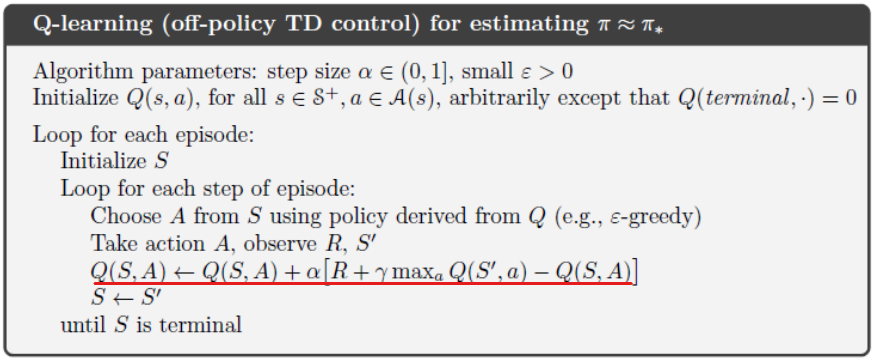

In [ ]:
#############################################
#                Agent Class                #
#############################################
class AgentQlearning():
  def __init__(self):
    self.q_table = np.zeros((x_size,y_size,4)) # x size, y size, number of action
    self.eps = 0.9
    self.alpha = 0.1

  def select_action(self, s):
    # epsilon-soft greedy policy
    x, y = s
    prob =  random.random()
    if prob < self.eps: # perform random action with epsilon probabilty
      action = random.randint(0,3)
    else: # greedy
      action_val = self.q_table[x,y,:]
      action = np.argmax(action_val)
    return action

  def update_table(self, transition):
    # Now, input for the update is a sigle state transition
    s,a,r,s_next = transition
    x,y = s
    x_next, y_next = s_next
    a_next = self.select_action(s_next) # Select an action for s_next (Not actually taken one)
    ##############################################################################
    # Fill Your Code!
    # Q-learning update
    self.q_table[x,y,a] = self.q_table[x,y,a] + self.alpha*(r + np.max(self.q_table[x_next, y_next,:]) - self.q_table[x,y,a])
    ###### 머 어떻게 전개하는듯 전개해서 alpha에 대해서 묶는다 !!!!!!!!!!!!!!!!!!!!!!!!!!!!111111111
    ##############################################################################

  def anneal_eps(self):
    # annealing part: You may safely ignore this part :) (by Han)
    self.eps -= 0.03
    self.eps = max(self.eps, 0.1)

  def show_table(self):
    # Show me the one action of which results in the best Q(s,a) value
    q_list = self.q_table.tolist()
    best_qvalue = np.zeros((x_size,y_size))
    best_action = np.zeros((x_size,y_size))
    for row_idx in range(len(q_list)):
      row = q_list[row_idx]
      for col_idx in range(len(row)):
        col = row[col_idx]
        qvalue = np.max(col)
        action = np.argmax(col)
        best_qvalue[row_idx, col_idx] = qvalue
        best_action[row_idx, col_idx] = action
    return best_qvalue, best_action

### [2] Main(Learning)

In [ ]:
#############################################
#                   Main                    #
#############################################
env = GridWorld()
agent = AgentQlearning()

for n_epi in tqdm(range(0, 100000), desc='Processing', unit='%', position=0, leave=True):
    done = False

    s = env.reset()
    while not done:
        a = agent.select_action(s)
        s_next, r, done = env.step(a)
        agent.update_table((s, a, r, s_next))
        ########################################################
        # Fill your code
        s = s_next
        ########################################################
    agent.anneal_eps()

### [3] Plot Value Function

In [ ]:
#############################################
#           Plot Vlaue Functiron            #
#############################################
# Display the opt_q
fig = plt.figure(figsize=(x_size*1.2, y_size*1.2))
ax = fig.add_subplot()

# Show me the result when it has done!
opt_q, opt_policy = agent.show_table()

# get min, max opt_q
vmin = np.min(opt_q)
vmax = np.max(opt_q)

# set obstacles value -9999
for (x,y) in Obstacles:
  opt_q[x][y] = -9999

# Define your own colormap for better visibility
cmap = plt.get_cmap('summer', 256)
cmap.set_under('red')

# Display the image with colorbar
img = plt.imshow(opt_q, cmap=cmap, interpolation='nearest', vmin=vmin*1.05, vmax=vmax)
for x in range(x_size):
    for y in range(y_size):
        if x == x_goal and y == y_goal:
            tempstr = "Goal"
        elif (x, y) in Obstacles:
            tempstr = "Obst"
        else :
            tempstr = "{:.1f}".format(opt_q[x][y])
        text = ax.text(y, x, tempstr, ha="center", va="center", color="k", size="12")

cbar = plt.colorbar(img)
plt.show()

### [4] Plot Policy

In [ ]:
#############################################
#           Plot Vlaue Functiron            #
#############################################
# Display the opt_q
fig = plt.figure(figsize=(x_size*1.2, y_size*1.2))
ax = fig.add_subplot()

# Show me the result when it has done!
opt_q, opt_policy = agent.show_table()

# get min, max opt_q
vmin = np.min(opt_q)
vmax = np.max(opt_q)

# set obstacles value -9999
for (x,y) in Obstacles:
  opt_q[x][y] = -9999

# Define your own colormap for better visibility
cmap = plt.get_cmap('summer', 256)
cmap.set_under('red')

# Display the image with colorbar
img = plt.imshow(opt_q, cmap=cmap, interpolation='nearest', vmin=vmin-3, vmax=vmax)
for x in range(x_size):
    for y in range(y_size):
        if x == x_goal and y == y_goal:
            tempstr = "Goal"
        elif (x, y) in Obstacles:
            tempstr = "Obst"
        elif opt_policy[x][y] == 0:
            tempstr = "↑"
        elif opt_policy[x][y] == 1:
            tempstr = "↓"
        elif opt_policy[x][y] == 2:
            tempstr = "→"
        elif opt_policy[x][y] == 3:
            tempstr = "←"
        text = ax.text(y, x, tempstr, ha="center", va="center", color="k", size="17")

cbar = plt.colorbar(img)
plt.show()

# **3. Model-Free MDP Solver(With Error)**

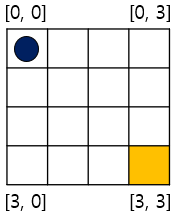

- State Set $X= \{(0, 0), (0, 1), \cdots  ,(x,y)\}$

- Agent action set $U = \{ ↑, ↓, ←, →\}$

- Nature action set $Θ= \{⋅, ↑, ↓, ←, →\}$

- State transition probability : **action 확률적으로 수행**

- Reward function

  $r(x, u) = \left\{ \begin{matrix} -100 & If \; x = x_{obst}\\ -1 & o/w  \end{matrix} \right.$

- Initial state $x_{I} \in X$

- Goal state $x_{G} = (x_G, y_G)$

- Policy $\pi(x_k) = u_k$

### [0] Environment Class

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#############################################
#           GridWorld Parameters            #
#############################################
x_size = 20
y_size = 10
x_goal = 9
y_goal = 9
x_obstacles = [4, 4, 5, 6, 17, 10]
y_obstacles = [4, 9, 1, 7, 3, 9]
Obstacles = list(zip(x_obstacles, y_obstacles))
Perr = 0.3  # Error 확률


#############################################
#           GridWorld Environment           #
#############################################
class GridWorld_Error():
    def __init__(self):
        self.x = 0
        self.y = 0

    def step(self, a):
        # Action set U = [↑, ↓, →, ←] = [u1, u2, u3, u4] = [0, 1, 2, 3]
        # Nature Action Step
        if a == 0:
            Na = np.random.choice([0, 2, 3], p=[1-Perr, Perr/2, Perr/2])
        elif a == 1:
            Na = np.random.choice([1, 2, 3], p=[1-Perr, Perr/2, Perr/2])
        elif a == 2:
            Na = np.random.choice([2, 0, 1], p=[1-Perr, Perr/2, Perr/2])
        elif a == 3:
            Na = np.random.choice([3, 0, 1], p=[1-Perr, Perr/2, Perr/2])

        # Robot Action Step
        if Na == 0:
            self.move_up()
        elif Na == 1:
            self.move_down()
        elif Na == 2:
            self.move_right()
        elif Na == 3:
            self.move_left()

        # Compute Reward
        if (self.x, self.y) in Obstacles:
            reward = -100
            self.reset()
        else:
            reward = -1

        # Compute Done!
        done = self.is_done()

        return (self.x, self.y), reward, done

    def move_right(self):
        self.y += 1
        if self.y > y_size-1:
            self.y-=1

    def move_left(self):
        self.y -= 1
        if self.y < 0:
            self.y+=1

    def move_up(self):
        self.x -= 1
        if self.x < 0:
            self.x+=1

    def move_down(self):
        self.x += 1
        if self.x > x_size-1:
            self.x-=1

    def is_done(self):
        if self.x == x_goal and self.y == y_goal:
            return True
        else:
            return False

    def get_state(self):
        return (self.x, self.y)

    def reset(self):
        self.x = np.random.choice([0, x_size-1])
        self.y = np.random.choice([0, y_size-1])
        return (self.x, self.y)

## **(1) SARSA**

### [1] SARSA Agent Class

In [ ]:
# Same with previous case.

### [2] Main(Learning)

In [ ]:
#############################################
#                   Main                    #
#############################################
env = GridWorld_Error()
agent = AgentSARSA()

for n_epi in tqdm(range(0, 50000), desc='Processing', unit='%', position=0, leave=True):
    done = False

    s = env.reset()
    a = agent.select_action(s)
    while not done:
        s_next, r, done = env.step(a)
        a_next = agent.update_table((s, a, r, s_next))
        ########################################################
        # Fill your variable
        s = s_next
        a = a_next
        ########################################################
    agent.anneal_eps()

### [3] Plot Value Function

In [ ]:
#############################################
#           Plot Vlaue Functiron            #
#############################################
# Display the opt_q
fig = plt.figure(figsize=(x_size*1.2, y_size*1.2))
ax = fig.add_subplot()

# Show me the result when it has done!
opt_q, opt_policy = agent.show_table()

# get min, max opt_q
vmin = np.min(opt_q)
vmax = np.max(opt_q)

# set obstacles value -9999
for (x,y) in Obstacles:
  opt_q[x][y] = -9999

# Define your own colormap for better visibility
cmap = plt.get_cmap('summer', 256)
cmap.set_under('red')

# Display the image with colorbar
img = plt.imshow(opt_q, cmap=cmap, interpolation='nearest', vmin=vmin*1.05, vmax=vmax)
for x in range(x_size):
    for y in range(y_size):
        if x == x_goal and y == y_goal:
            tempstr = "Goal"
        elif (x, y) in Obstacles:
            tempstr = "Obst"
        else :
            tempstr = "{:.1f}".format(opt_q[x][y])
        text = ax.text(y, x, tempstr, ha="center", va="center", color="k", size="12")

cbar = plt.colorbar(img)
plt.show()

### [4] Plot Policy

In [ ]:
#############################################
#           Plot Vlaue Functiron            #
#############################################
# Display the opt_q
fig = plt.figure(figsize=(x_size*1.2, y_size*1.2))
ax = fig.add_subplot()

# Show me the result when it has done!
opt_q, opt_policy = agent.show_table()

# get min, max opt_q
vmin = np.min(opt_q)
vmax = np.max(opt_q)

# set obstacles value -9999
for (x,y) in Obstacles:
  opt_q[x][y] = -9999

# Define your own colormap for better visibility
cmap = plt.get_cmap('summer', 256)
cmap.set_under('red')

# Display the image with colorbar
img = plt.imshow(opt_q, cmap=cmap, interpolation='nearest', vmin=vmin*1.05, vmax=vmax)
for x in range(x_size):
    for y in range(y_size):
        if x == x_goal and y == y_goal:
            tempstr = "Goal"
        elif (x, y) in Obstacles:
            tempstr = "Obst"
        elif opt_policy[x][y] == 0:
            tempstr = "↑"
        elif opt_policy[x][y] == 1:
            tempstr = "↓"
        elif opt_policy[x][y] == 2:
            tempstr = "→"
        elif opt_policy[x][y] == 3:
            tempstr = "←"
        text = ax.text(y, x, tempstr, ha="center", va="center", color="k", size="17")

cbar = plt.colorbar(img)
plt.show()

## **(2) Q-Learning**

### [1] Q-Learning Agent Class

In [ ]:
# Same with previous case.

### [2] Main(Learning)

In [ ]:
#############################################
#                   Main                    #
#############################################
env = GridWorld_Error()
agent = AgentQlearning()

for n_epi in tqdm(range(0, 50000), desc='Processing', unit='%', position=0, leave=True):
    done = False

    s = env.reset()
    while not done:
        a = agent.select_action(s)
        s_next, r, done = env.step(a)
        agent.update_table((s, a, r, s_next))
        ########################################################
        # Fill your code
        s = s_next
        ########################################################
    agent.anneal_eps()

### [3] Plot Value Function

In [ ]:
#############################################
#           Plot Vlaue Functiron            #
#############################################
# Display the opt_q
fig = plt.figure(figsize=(x_size*1.2, y_size*1.2))
ax = fig.add_subplot()

# Show me the result when it has done!
opt_q, opt_policy = agent.show_table()

# get min, max opt_q
vmin = np.min(opt_q)
vmax = np.max(opt_q)

# set obstacles value -9999
for (x,y) in Obstacles:
  opt_q[x][y] = -9999

# Define your own colormap for better visibility
cmap = plt.get_cmap('summer', 256)
cmap.set_under('red')

# Display the image with colorbar
img = plt.imshow(opt_q, cmap=cmap, interpolation='nearest', vmin=vmin*1.05, vmax=vmax)
for x in range(x_size):
    for y in range(y_size):
        if x == x_goal and y == y_goal:
            tempstr = "Goal"
        elif (x, y) in Obstacles:
            tempstr = "Obst"
        else :
            tempstr = "{:.1f}".format(opt_q[x][y])
        text = ax.text(y, x, tempstr, ha="center", va="center", color="k", size="12")

cbar = plt.colorbar(img)
plt.show()

### [4] Plot Policy

In [ ]:
#############################################
#           Plot Vlaue Functiron            #
#############################################
# Display the opt_q
fig = plt.figure(figsize=(x_size*1.2, y_size*1.2))
ax = fig.add_subplot()

# Show me the result when it has done!
opt_q, opt_policy = agent.show_table()

# get min, max opt_q
vmin = np.min(opt_q)
vmax = np.max(opt_q)

# set obstacles value -9999
for (x,y) in Obstacles:
  opt_q[x][y] = -9999

# Define your own colormap for better visibility
cmap = plt.get_cmap('summer', 256)
cmap.set_under('red')

# Display the image with colorbar
img = plt.imshow(opt_q, cmap=cmap, interpolation='nearest', vmin=vmin-3, vmax=vmax)
for x in range(x_size):
    for y in range(y_size):
        if x == x_goal and y == y_goal:
            tempstr = "Goal"
        elif (x, y) in Obstacles:
            tempstr = "Obst"
        elif opt_policy[x][y] == 0:
            tempstr = "↑"
        elif opt_policy[x][y] == 1:
            tempstr = "↓"
        elif opt_policy[x][y] == 2:
            tempstr = "→"
        elif opt_policy[x][y] == 3:
            tempstr = "←"
        text = ax.text(y, x, tempstr, ha="center", va="center", color="k", size="17")

cbar = plt.colorbar(img)
plt.show()

!!!!!!!! error를 넣게 되면 더 피해가게 될 것이다. 미끄러질 확률이 높아지므로 !!!!!!!